In [198]:
#以下部分定义一个决策树模型实现对winequality-red.csv数据集的分类
import pandas as pd
data = pd.read_csv('winequality-red.csv',sep=';')
import numpy as np
data = np.array(data)
import matplotlib.pyplot as plt
print(data)

[[ 7.4    0.7    0.    ...  0.56   9.4    5.   ]
 [ 7.8    0.88   0.    ...  0.68   9.8    5.   ]
 [ 7.8    0.76   0.04  ...  0.65   9.8    5.   ]
 ...
 [ 6.3    0.51   0.13  ...  0.75  11.     6.   ]
 [ 5.9    0.645  0.12  ...  0.71  10.2    5.   ]
 [ 6.     0.31   0.47  ...  0.66  11.     6.   ]]


In [199]:
#Count the sample size for different categories by the last column
count = np.array([0]*10)
for i in range(len(data)):
    count[int(data[i][-1])] = count[int(data[i][-1])] + 1
#打印每个类别的样本数量->仅仅针对较多的类别进行预测
print(count)

[  0   0   0  10  53 681 638 199  18   0]


In [200]:
#把导入的数据集根据最后一列的值进行分类，5,6合并为一类，其余的为一类，分为两个新的数据集
data1 = []
data2 = []
for i in range(len(data)):
    if data[i][-1] == 5 or data[i][-1] == 6:
        data1.append(data[i])
    else:
        data2.append(data[i])
data1 = np.array(data1)
data2 = np.array(data2)
print(data1)
print(data2)
print(len(data1))
print(len(data2))

[[ 7.4    0.7    0.    ...  0.56   9.4    5.   ]
 [ 7.8    0.88   0.    ...  0.68   9.8    5.   ]
 [ 7.8    0.76   0.04  ...  0.65   9.8    5.   ]
 ...
 [ 6.3    0.51   0.13  ...  0.75  11.     6.   ]
 [ 5.9    0.645  0.12  ...  0.71  10.2    5.   ]
 [ 6.     0.31   0.47  ...  0.66  11.     6.   ]]
[[ 7.3   0.65  0.   ...  0.47 10.    7.  ]
 [ 7.8   0.58  0.02 ...  0.57  9.5   7.  ]
 [ 8.5   0.28  0.56 ...  0.75 10.5   7.  ]
 ...
 [ 7.4   0.36  0.3  ...  0.7  11.4   8.  ]
 [ 7.    0.56  0.17 ...  0.68 10.55  7.  ]
 [ 6.7   0.32  0.44 ...  0.8  11.6   7.  ]]
1319
280


In [201]:
#划分数据集为1:4,使用numpy的random.shuffle()函数
np.random.shuffle(data)
train_data = data[:int(len(data)*0.8)]
test_data = data[int(len(data)*0.8):]

print(train_data,len(train_data))
print(test_data,len(test_data))
n = train_data.shape[1]
print(n)

[[12.5   0.46  0.63 ...  0.87 10.2   5.  ]
 [ 7.    0.5   0.25 ...  0.63  9.2   5.  ]
 [12.2   0.45  0.49 ...  0.63 10.4   5.  ]
 ...
 [ 7.6   0.36  0.31 ...  0.62  9.5   6.  ]
 [ 6.4   0.67  0.08 ...  0.49 11.4   6.  ]
 [ 7.2   1.    0.   ...  0.46 10.    5.  ]] 1279
[[9.20e+00 5.20e-01 1.00e+00 ... 2.00e+00 9.40e+00 4.00e+00]
 [7.70e+00 7.15e-01 1.00e-02 ... 5.70e-01 1.18e+01 6.00e+00]
 [1.00e+01 3.10e-01 4.70e-01 ... 8.00e-01 1.05e+01 7.00e+00]
 ...
 [9.10e+00 3.60e-01 3.90e-01 ... 8.20e-01 1.10e+01 7.00e+00]
 [7.30e+00 7.35e-01 0.00e+00 ... 6.00e-01 9.40e+00 5.00e+00]
 [6.00e+00 5.00e-01 4.00e-02 ... 4.70e-01 1.00e+01 5.00e+00]] 320
12


In [202]:
#定义feature项为前11列，label项为最后一列
train_feature = train_data[:,:-1]
#再次切分出train_feature的前8列为train_feature1
train_label = train_data[:,-1]
test_feature = test_data[:,:-1]
test_label = test_data[:,-1]
#print(train_feature)
#获取列数
n = train_feature.shape[1]
print(n)
print(train_label)

11
[5. 5. 5. ... 6. 6. 5.]


In [203]:
#给前11列添加一个标签，用于后续的决策树的构建
feature_label = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
print(len(feature_label))

11


In [204]:
# #将训练集和测试集标准化
# train_feature = (train_feature - np.mean(train_feature,axis=0))/np.std(train_feature,axis=0)
# test_feature = (test_feature - np.mean(test_feature,axis=0))/np.std(test_feature,axis=0)
# print(train_feature)
# print(test_feature)
# #打印数据的形状
# print(train_feature.shape)
# print(test_feature.shape)

In [205]:
# #利用直方均衡化的方案放大特征的差异
# def histogram_equalization(data):
#     # 统计每一列特征的直方分布
#     hist, bins = np.histogram(data, bins='auto')

#     # 计算累积分布函数
#     cdf = hist.cumsum()
#     cdf_normalized = cdf / cdf[-1]

#     # 根据累积分布函数进行直方均衡化
#     equalized_data = np.interp(data, bins[:-1], cdf_normalized)
#     return equalized_data

# #保存直方均衡化前的数据
# original_train_feature = train_feature
# original_test_feature = test_feature

# #对训练集和测试集进行直方均衡化
# train_feature = histogram_equalization(train_feature)
# test_feature = histogram_equalization(test_feature)

# #把区间[0,1]的数据映射到[0,100]的整数区间
# #计算区间缩放比例->可以调制的超参数
# scale = 10/(np.max(train_feature)-np.min(train_feature))
# train_feature = (train_feature-np.min(train_feature))*scale
# test_feature = (test_feature-np.min(test_feature))*scale
# # train_feature = train_feature*50
# # test_feature = test_feature*50

# #把均衡化后的数据取整
# train_feature = np.round(train_feature)
# test_feature = np.round(test_feature)

# #绘制前后的直方图
# for i in range(len(train_feature[0])):
#     plt.subplot(2,6,i+1)
#     plt.hist(original_train_feature[:,i],bins='auto')
#     plt.title(feature_label[i])
#     #字体改大一些
# plt.tight_layout()
# plt.show()
# for i in range(len(train_feature[0])):
#     plt.subplot(2,6,i+1)
#     plt.hist(train_feature[:,i],bins='auto')
#     plt.title(feature_label[i])
# plt.tight_layout()
# plt.show()
# #打印数据
# print(train_feature)


In [206]:
# #把数据集的前11列的每一列中的数据首先除以该列的最大值，再按四舍五入的方式转换为整数
# train_feature = np.round(10*train_feature/np.max(train_feature,axis=0))
# test_feature = np.round(10*test_feature/np.max(test_feature,axis=0))
# print(train_feature)
# print(test_feature)
# #打印第11列
# print(train_feature[:,10])


In [207]:
#把train_feature和train_label合并为新的数据集train_data
train_data = np.hstack((train_feature,train_label.reshape(-1,1)))
test_data = np.hstack((test_feature,test_label.reshape(-1,1)))
print(train_data.shape)
print(test_data.shape)
print(feature_label[10])
print(train_data[:,10])

(1279, 12)
(320, 12)
alcohol
[10.2  9.2 10.4 ...  9.5 11.4 10. ]


In [208]:

def data_binarization(data):
    #对每一列都找到合适的划分阈值
    split = []#存储每个特征的划分阈值
    #每个特征分别处理，首先对每一列的数据进行排序，然后针对每一个划分线计算信息增益，选择最大的信息增益对应的划分线
    for i in range(len(data[0])-1):
        #拷贝一份数据
        data_copy = data.copy()
        #对每一列的数据进行排序
        data_copy = data_copy[np.argsort(data_copy[:,i])]
        #对其中的每一个划分线计算信息增益
        max_info_gain = 0
        split_value = 0
        for j in range(len(data_copy)-1):
            #计算当前划分线的信息增益
            info_gain = calc_info_gain(data_copy,j,i)
            if info_gain > max_info_gain:
                max_info_gain = info_gain
                split_value = (data_copy[j][i]+data_copy[j+1][i])/2
        split.append(split_value)
#对每一列的数据进行二值化处理
    print(split)
    for i in range(len(data[0])-1):
        for j in range(len(data)):
            if data[j][i] > split[i]:
                data[j][i] = 1
            else:
                data[j][i] = 0
    return split

def calc_info_gain(data,split_index,feature_index):
    #计算当前划分线的信息增益
    #计算划分线左边的数据集的香农熵
    left_data = data[:split_index+1]
    left_entropy = calc_shannon_entropy(left_data)
    #计算划分线右边的数据集的香农熵
    right_data = data[split_index+1:]
    right_entropy = calc_shannon_entropy(right_data)
    #计算划分线的信息增益
    info_gain = calc_shannon_entropy(data) - (len(left_data)/len(data))*left_entropy - (len(right_data)/len(data))*right_entropy
    return info_gain

def calc_shannon_entropy(data):
    #计算数据集的香农熵
    #计算数据集中的样本总数
    num_samples = len(data)
    #计算数据集中每个类别的样本数
    count = np.array([0]*10)
    for i in range(len(data)):
        count[int(data[i][-1])] = count[int(data[i][-1])] + 1
    #计算数据集的香农熵
    shannon_entropy = 0
    for i in range(len(count)):
        if count[i] != 0:
            shannon_entropy = shannon_entropy - (count[i]/num_samples)*np.log2(count[i]/num_samples)
    return shannon_entropy

split=data_binarization(train_data)
#用训练集的划分线对测试集进行二值化处理
for i in range(len(test_data[0])-1):
    for j in range(len(test_data)):
        if test_data[j][i] > split[i]:
            test_data[j][i] = 1
        else:
            test_data[j][i] = 0
# data_binarization(test_data)
print(train_data)
print(test_data)

[10.0, 0.41, 0.29, 3.4, 0.075, 7.0, 58.0, 0.99538, 3.29, 0.62, 10.6]
[[1. 1. 1. ... 1. 0. 5.]
 [0. 1. 0. ... 1. 0. 5.]
 [1. 1. 1. ... 1. 0. 5.]
 ...
 [0. 0. 1. ... 0. 0. 6.]
 [0. 1. 0. ... 0. 1. 6.]
 [0. 1. 0. ... 0. 0. 5.]]
[[0. 1. 1. ... 1. 0. 4.]
 [0. 1. 0. ... 0. 1. 6.]
 [0. 0. 1. ... 1. 0. 7.]
 ...
 [0. 0. 1. ... 1. 1. 7.]
 [0. 1. 0. ... 0. 0. 5.]
 [0. 1. 0. ... 0. 0. 5.]]


In [209]:
#选择最优特征
def chooseBestFeatureToSplit(dataset):
    numFeatures = len(dataset[0]) - 1
    baseEntropy = calcShannonEnt(dataset)#计算原始数据集的香农熵
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):
      #获取dataSet的第i个所有特征
      featList = [example[i] for example in dataset]
      uniqueVals = set(featList)
      newEntropy = 0.0
      for value in uniqueVals:
        #在value中找到一个划分线，把数据集划分为两个子集
        subDataSet = splitDataSet(dataset,i,value)#subDataSet划分后的子集
        prob = len(subDataSet)/float(len(dataset))#计算子集的概率
        newEntropy += prob * calcShannonEnt(subDataSet)#计算分岔之后的香农熵
      infoGain = baseEntropy - newEntropy#信息增益
      # print("第%d个特征的增益为%.3f"%(i,infoGain))
      #计算信息增益比
      infoGainRate = infoGain / baseEntropy
      #计算基尼系数
      # gini = calcGini(subDataSet)
      #通过比较选择最大的信息增益比
      if (infoGainRate > bestInfoGain):
        bestInfoGain = infoGainRate
        bestFeature = i
      # if (infoGain > bestInfoGain):
      #   bestInfoGain = infoGain
      #   bestFeature = i
    return bestFeature

In [210]:
#计算当前数据集中的各个类别的数量，返回数量最多的类别
import operator
def majorityCnt(classList):
  classCount = {}#存储各个类别的数量
  for vote in classList:
    if vote not in classCount.keys():
      classCount[vote] = 0
    classCount[vote] += 1
  sortedClassCount = sorted(classCount.items(),key = operator.itemgetter(1),reverse = True)
  return sortedClassCount[0][0]

In [211]:
#创建树的节点模型
def createTree(dataset,labels,feature_labels):
  #判断数据集中的所有数据是否属于同一类别
  classList = [example[-1] for example in dataset]
  if classList.count(classList[0]) == len(classList):
    return classList[0]
    #判断数据集是否只有一列,可能仍然不纯
  if len(dataset[0]) == 1:
    return majorityCnt(classList)
    #选择最优的列，得到最优列对应的label含义
  bestFeat = chooseBestFeatureToSplit(dataset)
  bestFeatLabel = labels[bestFeat]#最优列的标签
  feature_labels.append(bestFeatLabel)
  #初始化myTree
  myTree = {bestFeatLabel:{}}
  del (labels[bestFeat])#删除已经使用特征标签
  #得到训练集中所有最优列的属性值
  featValues = [example[bestFeat] for example in dataset]#当前列
  uniqueVals = set(featValues)#去掉重复的属性值
  for value in uniqueVals:
      subLabels = labels[:]#子集合
      myTree[bestFeatLabel][value] = createTree(splitDataSet(dataset,bestFeat,value),subLabels,feature_labels)
  return myTree

计算香农熵的公式为：i表示第i个特征，n表示特征的取值个数，p(xi)表示第i个特征取值为xi的概率
$$H=-\sum_{i=1}^{n}p(x_i)log_2p(x_i)$$

In [212]:
#计算香农熵
import math
def calcShannonEnt(dataset):
  numEntries = len(dataset)#计算数据集中实例的总数
  labelCounts = {}#创建字典，它的键值是最后一列的数值
  for featVec in dataset:
    currentLabel = featVec[-1]#提取标签信息
    if currentLabel not in labelCounts.keys():
      labelCounts[currentLabel] = 0
    labelCounts[currentLabel] += 1#每个类别出现的次数
  shannonEnt = 0.0
  for key in labelCounts:
    prob = float(labelCounts[key])/numEntries#选择该标签的概率
    shannonEnt -= prob * math.log(prob,2)#计算香农熵
  return shannonEnt

In [213]:
#按照给定特征划分数据集->决策树分岔
def splitDataSet(dataset,axis,value):
  retDataSet = []#创建返回的数据集列表
  for featVec in dataset:
    if featVec[axis] == value:
      reducedFeatVec = np.concatenate((featVec[:axis],featVec[axis+1:]))
      retDataSet.append(reducedFeatVec)
  return retDataSet

In [214]:
#定义一个函数计算决策树的深度
def getTreeDepth(myTree):
  maxDepth = 0
  firstStr = list(myTree.keys())[0]#获取决策树的第一个节点
  secondDict = myTree[firstStr]#下一个字典
  for key in secondDict.keys():
    if type(secondDict[key]).__name__ == 'dict':
      thisDepth = 1 + getTreeDepth(secondDict[key])
    else:
      thisDepth = 1
    if thisDepth > maxDepth:
      maxDepth = thisDepth
  return maxDepth


In [215]:
def getNumLeafs(myTree):
  numLeafs = 0
  firstStr = list(myTree.keys())[0]#获取决策树的第一个节点
  secondDict = myTree[firstStr]#获取下一组字典
  for key in secondDict.keys():
    if type(secondDict[key]).__name__ == 'dict':
      numLeafs += getNumLeafs(secondDict[key])
    else:
      numLeafs += 1
  return numLeafs

In [216]:
#定义一个小数据集对决策树的构建进行测试
dataset = [[1,1,'yes'],
           [1,1,'yes'],
           [1,0,'no'],
           [0,1,'no'],
           [0,1,'no']]
labels = ['no surfacing','flippers']
feature_labels = []
myTree = createTree(dataset,labels,feature_labels)
print(myTree)

getNumLeafs(myTree)
# #绘制决策树
# createPlot(myTree)
print(getTreeDepth(myTree))


{'no surfacing': {0: 'no', 1: {'flippers': {'1': 'yes', '0': 'no'}}}}
2


In [217]:
#测试决策树的构建
featurelabels = []
print(feature_label)
print(train_data)
myTree = createTree(train_data,feature_label,featurelabels)
print(myTree)
#构建回归树
# myTree1 = create_regression_tree(train_data,feature_label,feature_labels)


['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
[[1. 1. 1. ... 1. 0. 5.]
 [0. 1. 0. ... 1. 0. 5.]
 [1. 1. 1. ... 1. 0. 5.]
 ...
 [0. 0. 1. ... 0. 0. 6.]
 [0. 1. 0. ... 0. 1. 6.]
 [0. 1. 0. ... 0. 0. 5.]]
{'alcohol': {0.0: {'sulphates': {0.0: {'total sulfur dioxide': {0.0: {'pH': {0.0: {'residual sugar': {0.0: {'citric acid': {0.0: {'free sulfur dioxide': {0.0: {'volatile acidity': {0.0: 5.0, 1.0: {'chlorides': {0.0: {'density': {0.0: {'fixed acidity': {5.0: 5.0, 6.0: 6.0}}, 1.0: {'fixed acidity': {5.0: 5.0, 6.0: 6.0}}}}, 1.0: {'density': {0.0: 5.0, 1.0: {'fixed acidity': {4.0: 4.0, 5.0: 5.0, 6.0: 6.0}}}}}}}}, 1.0: {'density': {0.0: 5.0, 1.0: {'volatile acidity': {0.0: 5.0, 1.0: {'chlorides': {0.0: {'fixed acidity': {5.0: 5.0, 6.0: 6.0}}, 1.0: {'fixed acidity': {5.0: 5.0, 6.0: 6.0}}}}}}}}}}, 1.0: {'chlorides': {0.0: {'fixed acidity': {0.0: {'free sulfur dioxide': {

In [218]:
#写一个函数检测决策树的根节点开始到一个随机的叶子节点包含的特征数
print(getTreeDepth(myTree))

11


In [219]:
#在测试集上测试决策树
# %%script false

def classify(inputTree,featLabels,testVec,TreeRoute={}):
  # classLabel = ''
  # Treeroute = []
  firstStr = list(inputTree.keys())[0]#获取决策树的第一个特征属性,表示当前判断的特征
  #获取当前判断的特征的取值
  feature_value = [key for key in inputTree[firstStr].keys()] 
  # secondDict = inputTree[firstStr]#获取第一个属性的值,表示当前判断的特征的取值
  featIndex = featLabels.index(firstStr)#将标签字符串转换为索引
  #从测试向量中获取当前判断的特征的取值
  test_value = testVec[featIndex]

  # print(feature_value)
  # print(firstStr,test_value)

  #进入字典结构中对应当前判断的特征的取值最近的子树
  min_diastance = 1000
  for key in feature_value:
     distance=abs(key-test_value)
     if distance<min_diastance:
        min_diastance=distance
        test_value=key
   
  secondDict = inputTree[firstStr][test_value]    
  if isinstance(secondDict, dict):
    return classify(secondDict,featLabels,testVec)
  else:
    #打印当前叶子节点包含的全部特征取值
    # print(secondDict)
    return secondDict


feature_label = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
print(len(feature_label))
#测试训练出的决策树,计算错误率
error = 0

for i in range(len(test_data)):
  test_result = classify(myTree,feature_label,test_data[i])
  # #取字典的最里面的值
  # test_result= list(test_result.values())[0]
  print(test_result,test_data[i][-1])
  if test_result != test_data[i][-1]:
    error += 1

print(error)
# print(test_data)
print("错误率为：%.3f"%(error/len(test_data)))


11
5.0 4.0
5.0 6.0
5.0 7.0
5.0 5.0
5.0 5.0
5.0 5.0
5.0 5.0
5.0 5.0
5.0 6.0
5.0 5.0
5.0 6.0
5.0 5.0
5.0 5.0
5.0 6.0
5.0 5.0
5.0 5.0
5.0 5.0
5.0 5.0
5.0 4.0
5.0 5.0
5.0 5.0
5.0 5.0
5.0 7.0
5.0 5.0
5.0 7.0
5.0 6.0
5.0 5.0
5.0 5.0
5.0 5.0
5.0 5.0
5.0 7.0
5.0 6.0
5.0 6.0
5.0 5.0
5.0 5.0
5.0 6.0
5.0 7.0
5.0 6.0
5.0 6.0
5.0 5.0
5.0 6.0
5.0 6.0
5.0 5.0
5.0 6.0
5.0 6.0
5.0 5.0
5.0 5.0
5.0 7.0
5.0 5.0
5.0 5.0
5.0 6.0
5.0 5.0
5.0 5.0
5.0 7.0
5.0 6.0
5.0 6.0
5.0 5.0
5.0 8.0
5.0 6.0
5.0 7.0
5.0 7.0
5.0 5.0
5.0 5.0
5.0 5.0
5.0 5.0
5.0 4.0
5.0 5.0
5.0 6.0
5.0 5.0
5.0 6.0
5.0 7.0
5.0 5.0
5.0 4.0
5.0 5.0
5.0 5.0
5.0 5.0
5.0 6.0
5.0 5.0
5.0 6.0
5.0 6.0
5.0 5.0
5.0 4.0
5.0 8.0
5.0 6.0
5.0 5.0
5.0 6.0
5.0 3.0
5.0 6.0
5.0 6.0
5.0 6.0
5.0 7.0
5.0 8.0
5.0 6.0
5.0 6.0
5.0 5.0
5.0 5.0
5.0 6.0
5.0 7.0
5.0 6.0
5.0 7.0
5.0 5.0
5.0 6.0
5.0 6.0
5.0 7.0
5.0 5.0
5.0 6.0
5.0 6.0
5.0 4.0
5.0 7.0
5.0 6.0
5.0 5.0
5.0 5.0
5.0 5.0
5.0 6.0
5.0 6.0
5.0 5.0
5.0 7.0
5.0 6.0
5.0 6.0
5.0 5.0
5.0 6.0
5.0 5.0
5.0 6.0
5.0 6.0
5.0 6

In [220]:
#绘制决策树
import matplotlib.pyplot as plt
#定义文本框和箭头格式
decisionNode = dict(boxstyle = "sawtooth",fc = "0.8")
leafNode = dict(boxstyle = "round4",fc = "0.8")
arrow_args = dict(arrowstyle = "<-")
#绘制带箭头的注解
def plotNode(nodeTxt,centerPt,parentPt,nodeType):
  createPlot.ax1.annotate(nodeTxt,xy = parentPt,xycoords = 'axes fraction',xytext = centerPt,textcoords = 'axes fraction',va = "center",ha = "center",bbox = nodeType,arrowprops = arrow_args)
#计算叶子节点的数目
def getNumLeafs(myTree):
  numLeafs = 0
  firstStr = list(myTree.keys())[0]#获取结点的标签
  secondDict = myTree[firstStr]#获取结点的值
  for key in secondDict.keys():
    if type(secondDict[key]).__name__ == 'dict':
      numLeafs += getNumLeafs(secondDict[key])
    else:
      numLeafs += 1
  return numLeafs
#计算树的层数
def getTreeDepth(myTree):
  maxDepth = 0
  firstStr = list(myTree.keys())[0]
  secondDict = myTree[firstStr]
  for key in secondDict.keys():
    if type(secondDict[key]).__name__ == 'dict':
      thisDepth = 1 + getTreeDepth(secondDict[key])
    else:
      thisDepth = 1
    if thisDepth > maxDepth:
      maxDepth = thisDepth
  return maxDepth
#在父子节点间填充文本信息
def plotMidText(cntrPt,parentPt,txtString):
  xMid = (parentPt[0] - cntrPt[0])/2.0 + cntrPt[0]
  yMid = (parentPt[1] - cntrPt[1])/2.0 + cntrPt[1]
  createPlot.ax1.text(xMid,yMid,txtString)
#绘制决策树
def plotTree(myTree,parentPt,nodeTxt):
  numLeafs = getNumLeafs(myTree)#获取叶节点的数目
  depth = getTreeDepth(myTree)#获取树的层数
  firstStr = list(myTree.keys())[0]#获取结点的标签
  cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW,plotTree.yOff)#确定节点的位置
  plotMidText(cntrPt,parentPt,nodeTxt)#在父子节点间填充文本信息
  plotNode(firstStr,cntrPt,parentPt,decisionNode)#绘制带箭头的注解
  secondDict = myTree[firstStr]#获取结点的值
  plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD#减少y的偏移
  for key in secondDict.keys():
    if type(secondDict[key]).__name__ == 'dict':
      plotTree(secondDict[key],cntrPt,str(key))#递归绘制决策树
    else:
      plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW#增加x的偏移
      plotNode(secondDict[key],(plotTree.xOff,plotTree.yOff),cntrPt,leafNode)#绘制带箭头的注解
      plotMidText((plotTree.xOff,plotTree.yOff),cntrPt,str(key))#在父子节点间填充文本信息
  plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD#增加y的偏移
#创建绘图区
def createPlot(inTree):
  fig = plt.figure(1,facecolor = 'white')
  fig.clf()
  axprops = dict(xticks = [],yticks = [])
  createPlot.ax1 = plt.subplot(111,frameon = False,**axprops)
  plotTree.totalW = float(getNumLeafs(inTree))
  plotTree.totalD = float(getTreeDepth(inTree))
  plotTree.xOff = -0.5/plotTree.totalW
  plotTree.yOff = 1.0
  plotTree(inTree,(0.5,1.0),'')
  plt.show()

# createPlot(myTree)

0.590625


d:\conda_envs\pytorch\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 0 ( ) missing from current font.
  func(*args, **kwargs)
d:\conda_envs\pytorch\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 20 () missing from current font.
  func(*args, **kwargs)
d:\conda_envs\pytorch\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 16 () missing from current font.
  func(*args, **kwargs)
d:\conda_envs\pytorch\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 8 ) missing from current font.
  func(*args, **kwargs)
d:\conda_envs\pytorch\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 24 () missing from current font.
  func(*args, **kwargs)
d:\conda_envs\pytorch\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 28 () missing from current font.
  func(*args, **kwargs)


<Figure size 720x720 with 0 Axes>

d:\conda_envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 0 ( ) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\conda_envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\conda_envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 16 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\conda_envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8 ) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\conda_envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\conda_envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


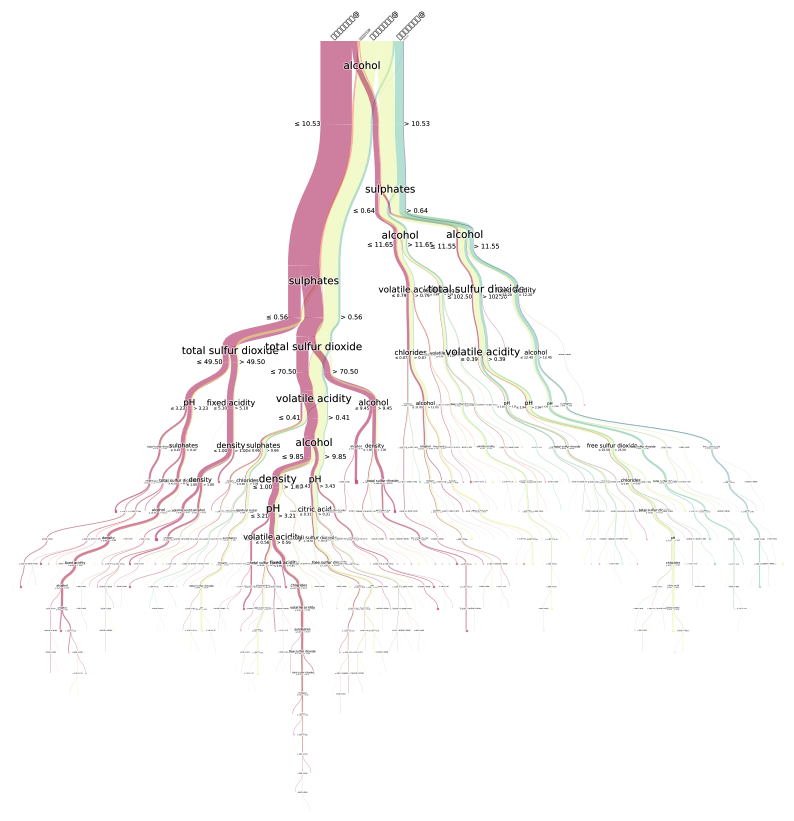

In [221]:
#用sklearn的决策树模型进行分类

data = pd.read_csv('winequality-red.csv',sep=';')
data  = np.array(data)
np.random.shuffle(data)
train_data = data[:int(len(data)*0.8)]
test_data = data[int(len(data)*0.8):]
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
train_feature = train_data[:,:-1]
train_label = train_data[:,-1]
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(train_feature,train_label)
#计算正确率
test_feature = test_data[:,:-1]
test_label = test_data[:,-1]
print(clf.score(test_feature,test_label))

#绘制决策树
import pybaobabdt
import pandas as pd
from scipy.io import arff
from sklearn.tree import DecisionTreeClassifier
import pygraphviz as pgv
from sklearn.tree import export_graphviz   
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from colour import Color
import matplotlib.pyplot as plt
import numpy as np
features = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']

ax = pybaobabdt.drawTree(clf, size=10, dpi=72, features=features, colormap='Spectral')


In [222]:
%%script false
#定义一个数据类，传入数据集，特征项，标签项，把特征项和特征项的标签合并为一列
class DataSetDT():
    def __init__(self, train_data, feature_label, label):
        #self.features作为一个字典，key为特征项的标签，value为特征项的值
        self.features = {}
        for i,feature_key in enumerate(feature_label):
             self.features[feature_key] = train_data[:,i]
        self.label = label
        #如果检查到某一列的特征项的值全为0，则删除该列

    
    #按数据集样本个数返回数据集的长度
    def __len__(self):
        return len(self.label)

    #删除标签为feature_key的字典键值对
    def delete(self,feature_key):
        del self.features[feature_key]
        #第0列删不了
    # def checkout(self):
    #     for key in self.features:
    #         if len(self.features[key]) == 0:
    #             del self.features[key]
       
#实例化数据类
train_data = DataSetDT(train_feature,feature_label,train_label)
test_data = DataSetDT(test_feature,feature_label,test_label)

#打印数据的类型
print(type(train_data))
# train_data.delete('fixed acidity')
print(train_data.features)
print(len(train_data))

Couldn't find program: 'false'
